In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.chdir('/content/drive/My Drive/Projects/reddit-vote-predictor')
import multiprocessing as mp
import sys
import shutil as sh
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as s
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime as dt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
# For object detection model:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image, ImageDraw
# For loading images from URL:
import requests
from io import BytesIO
from tqdm import tqdm

In [3]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Prints the GPU name

True
Tesla T4


#### Read in data

The previous scripts did the following
1. Scrape posts from a given subreddit (in this case r/dog and r/cat) within a given time frame
2. Delete posts not containing an image as the `post_hint`
3. Then use Reddit's API to pull additional data, such as `upvote_ratio`
4. Delete posts that have one upvote since this is indistinguishable from posts that received the default one upvote upon posting and nothing else.


In [119]:
dog = pd.read_csv('data/tbl/dog_praw.csv', index_col = None)
dog = dog.sort_values(by = 'created_date').reset_index(drop = True)
cat = pd.read_csv('data/tbl/cat_praw.csv', index_col = None)
cat = cat.sort_values(by = 'created_date').reset_index(drop = True)

#### Further filtering

1. Check that the image is hosted on reddit, else setup the script to download the thumbnail.
2. Then, check that the resultant link brings us to an image.

In [7]:
# If the image is not hosted on reddit, then use the url to the thumbnail
dog['FEATURE'] = dog.url
condition = ~dog.url.str.contains('redd.it')
dog.loc[condition, 'FEATURE'] = dog.loc[condition, 'thumbnail']
# for cat
cat['FEATURE'] = cat.url
condition = ~cat.url.str.contains('redd.it')
cat.loc[condition, 'FEATURE'] = cat.loc[condition, 'thumbnail']

In [10]:
# Check that images exist within the above-filtered url's
def check_image_exists(url):
    try:
        response = requests.get(url)
        return response.status_code == 200
    except requests.RequestException:
        return False

# Add a new column 'image_found' indicating if an image exists at the URL
#dog['image_found'] = dog['FEATURE'].apply(check_image_exists)
#cat['image_found'] = cat['FEATURE'].apply(check_image_exists)
# Also, parallelize this because it can take a while
n_cores = mp.cpu_count()
pool = mp.Pool(processes = n_cores)
dog['image_found'] = pool.map(check_image_exists, dog['FEATURE'])
cat['image_found'] = pool.map(check_image_exists, cat['FEATURE'])
pool.close()
pool.join()

In [18]:
print(f"{round(dog[dog['image_found']].shape[0] / dog.shape[0], 2)} percent of dog images exist.")
print(f"{round(cat[cat['image_found']].shape[0] / cat.shape[0], 2)} percent of cat images exist")

0.84 percent of dog images exist.
0.86 percent of cat images exist


#### Save the data frame with the new variable indicating the images that exist

In [108]:
dog[dog['image_found']].to_csv('data/tbl/dog_good-url.csv', index = False)
cat[cat['image_found']].to_csv('data/tbl/cat_good-url.csv', index = False)

#### Quick analysis of targets

1. Check temporal trend in `upvote_ratio` and `upvote`

In [4]:
# required modules (already loaded as above)
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt

def detrend_data(df, col_name, window_size=100, new_col_name = 'detrended'):
    """
    Detrend the data of a given column, creating a new column.

    Args:
        df (pd.DataFrame): DataFrame with 'Datetime' and 'Value' columns.
        col_name (str): Column name with continuous data to de-trend.
        window_size (int): Size of the moving average window.
        new_col_name (str): New column name with de-trended data.

    Returns:
        pd.DataFrame: DataFrame with an additional 'Detrended' column.
    """
    df[new_col_name] = df[col_name].rolling(window=window_size, min_periods=1).mean()
    return df

def make_plots(df, original, detrended, date_col):
    """
    Plot both the original data and the detrended data.

    Args:
        df (pd.DataFrame): DataFrame with `date_col`, `original`, and `detrended` columns.
        original (str): column name of original data
        detrended (str): column name of detrended column `original`
        date_col (str): x-axis, column of timestamps/dates
    """
    plt.figure(figsize=(12, 6))

    # Plot the original data without a trend
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df[original], marker='o', linestyle='-', label='Data without Trend', color='b')
    plt.xlabel(date_col)
    plt.ylabel(original)
    plt.title(f'Original {original} without a Linear Trend')
    plt.grid(True)
    plt.legend()

    # Plot the detrended data using the moving average filter
    plt.subplot(2, 1, 2)
    plt.plot(df.index, df[detrended], marker='o', linestyle='-', label='Detrended Data (Moving Average)', color='g')
    plt.xlabel(date_col)
    plt.ylabel(detrended)
    plt.title(f'Detrended {original} using Moving Average (Daily Granularity)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Create a sample DataFrame with datetime and value columns
def plot_detrended_data(df_, original_, dat_col_):
    new_data = detrend_data(df_, original_, window_size=50, new_col_name = 'detrended')
    make_plots(new_data, original_, 'detrended', 'created_date')

In [ ]:
# Plot dog upvote ratio
plot_detrended_data(dog, 'upvote_ratio', 'created_date')
# Plot cat upvote ratio
plot_detrended_data(cat, 'upvote_ratio', 'created_date')
# Plot dog upvotes
plot_detrended_data(dog, 'upvotes', 'created_date')
# Plot cat upvotes
plot_detrended_data(cat, 'upvotes', 'created_date')

#### Conclusions:

Upvote ratio doesn't have much of a trend, so just use as is.

For upvotes, larger window size would be better.

## Upvote Ratio Model Training

After analyzing the targets, upvote ratio is the better feature to predict since it is robust to autocorrelation unlike upvotes.

#### Preprocessing

1. Use a dog (or cat) detector to bound a box around a dog/cat
2. If none is found, don't use the image.
3. Crop around the bounding box using a center crop, but the center is the center of the bb
4. Save the images in a folder so that the dataloader doesn't have to deal with
skipping images if the above yields no image.
4. Transforms the dataloader will take care of:

  *   Resize all images
  *   Check color format is consistent across images
  *   Convert images to tensor

In [120]:
# Make some helper functions
def fd(df_):
  """
  -F-ilter the -D-ata using `image_found`
  """
  return df_[df_['image_found']]

#### Testing the object-detctor

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


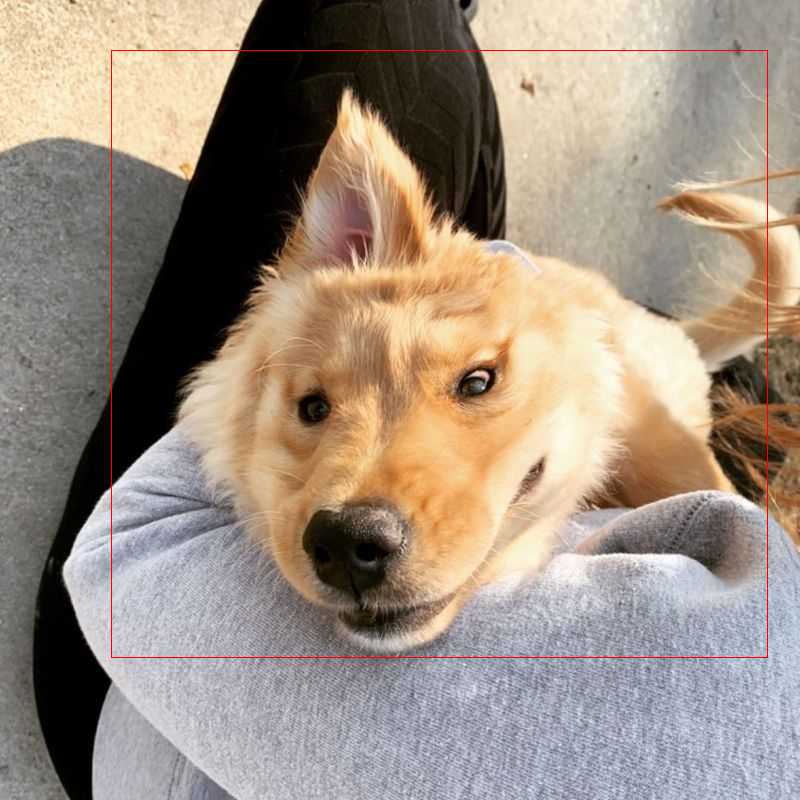

In [9]:
# required modules (already loaded as above)
# import torch
# import torchvision.transforms as T
# from torchvision.models.detection import fasterrcnn_resnet50_fpn
# from PIL import Image, ImageDraw
# import requests
# from io import BytesIO

# Load a pre-trained Faster R-CNN model (object-detection model)
# The label for dog is 18.
# Cat is 17
test_model = fasterrcnn_resnet50_fpn(pretrained=True)
test_model.eval()

# Get one URL (use the test image)
#url = fd(dog).FEATURE[0]
test_url = 'https://media.cnn.com/api/v1/images/stellar/prod/200313124810-02-rae-golden-retriever.jpg'
test_img_file = requests.get(test_url)
test_img = Image.open(BytesIO(test_img_file.content))

# Convert the image to tensor
test_transform = transforms.Compose([transforms.ToTensor()])
test_img_tensor = test_transform(test_img)

# Perform object detection
with torch.no_grad():
    test_predictions = test_model([test_img_tensor])

# Extract bounding box coordinates and labels
test_boxes = test_predictions[0]['boxes'].cpu().numpy()
test_labels = test_predictions[0]['labels'].cpu().numpy()

# Dogs are labelled 18 according to COCO
test_dog_label = 18

# Create a bounding box on the image around the dog.
# Cropping around detected dogs:
for test_box, test_label in zip(test_boxes, test_labels):
    if test_label == test_dog_label:
      # Get the bounding box dimensions
      x_min, y_min, x_max, y_max = map(int, test_box)
      test_cropped_img_tensor = test_img_tensor[:, y_min:y_max, x_min:x_max]

      # Convert the cropped tensor back to a PIL image to plot
      test_cropped_image_pil = transforms.ToPILImage()(test_cropped_img_tensor)
      # save image after cropping
      # cropped_image_pil.save('cropped_dog.jpg')

# Show the original image with a rectangle drawn on the bounding box
draw = ImageDraw.Draw(test_img)
for test_box, test_label in zip(test_boxes, test_labels):
    if test_label == test_dog_label:
        draw.rectangle([test_box[0], test_box[1], test_box[2], test_box[3]], outline="red")

# Save or display the original image with bounding boxes
# image.save('image_with_bboxes.jpg')  # Save the image with bounding boxes
test_img# Display the image with bounding boxes


In [12]:
list(test_img_tensor.shape)

[3, 800, 800]

#### Use the image-detection model on all images

1. Determine if there is a dog detected
2. obtain the center of the bounding box for each image

In [95]:
# # Test it
# # Get URL
# url_ = fd(dog).FEATURE[100]
# img_file = requests.get(url_)
# img = Image.open(BytesIO(img_file.content))

# # Convert to tensor
# transform = transforms.Compose([transforms.ToTensor()])
# img_tensor = transform(img)

# # object detection
# with torch.no_grad():
#     predictions = model([img_tensor])

# # Find the largest bounding box (if any)
# centers = [] # center of each bounding box for this image
# #labels = [] # T/F if the bounding box for this image contains a dog
# areas = [] # area of each bounding box in this image.
# for box, label in zip(boxes, labels):
#   if label == dog_label:
#     # Get the center of the bounding box.
#     x_min, y_min, x_max, y_max = map(int, box)
#     x = x_min + round((x_max - x_min) / 2) # midpont
#     y = y_min + round((y_max - y_min) / 2) # midpoint
#     centers.append([x, y])
#     # Get the bounding box area
#     area = (x_max - x_min) * (y_max - y_min)
#     areas.append(area)

# # If any label was dog, centers (and areas) are not empty
# if len(centers) > 0:
#   # Find the largest bounding box labelled dog
#   center = centers[np.nanargmax(areas)]
#   out = [True, int(center[0]), int(center[1])]
# else:
#   out = [None, None, None]

# print(centers)
# print(areas)
# print(out)

[[72, 40]]
[8050]
[True, 72, 40]


In [112]:
# # Test it using apply (also testing that the function version works)
# pd.concat([fd(dog.head(2)),
#            fd(dog.head(2)).apply(get_boundbox_center, axis = 1, result_type = 'expand')
# ], axis = 1)

,id,author,created_utc,is_video,num_comments,pinned,post_hint,retrieved_on,score,subreddit,...,praw_score,upvotes,downvotes,upvote_ratio,removed_by,FEATURE,image_found,has_dog,x,y
0,2zfdiu,yabeking,1426646659,NaN,0,NaN,image,1.440848e+09,4,DOG,...,3,3,0,0.72,NaN,http://b.thumbs.redditmedia.com/tgUBGKuyuj6sXH...,True,True,72,40
1,2zfi9w,sharongu,1426649300,NaN,0,NaN,image,1.440847e+09,3,DOG,...,3,3,0,1.00,NaN,http://b.thumbs.redditmedia.com/oXT7CJF8FaH4Eb...,True,True,57,95


#### Run object detection

In [4]:
# Download the model and define the transform in advance rather than each time.
model = fasterrcnn_resnet50_fpn(pretrained = True)
model.eval()
transform = transforms.Compose([transforms.ToTensor()])
dog_label = 18
cat_label = 17
def get_boundbox_center(df_row_, label_=None, transform_=None, model_=None, debug=False):
  """
  For each url, detect an object (dog is label_ = 18; label_ = 17 for cat).
  If none is found, return [None, None, None].
  Else, return [True, x, y], where x and y are the center coordinates of the bounding
  box around the largest detected bounding box pertaining to the object category.

  Arguments:
  df_row_ (pd.Series): the row of the data frame (from df.DataFrame.apply)
    from which an url will be taken pointing to an image (at index 'FEATURE')
  label_ (int): The label consistent with the object category output by model
  transform_ (torch.transform): Transformation for image prior to model prediction
  model_ (torch): Pretrained object-detection model
  debug (bool): If True, a global variable called `debug_df` will contain the
    shape of each tensor after transformation of each image prior to prediction.

  Value
  None. Nothing is returned because this was causing a connection timeout.
  Instead a `center_points` (data frame) is created in the global env, built
   row by row with the results for each image, similar to debug_df.
  """
  if 'center_points' not in globals().keys():
    global center_points
    center_points = pd.DataFrame(columns = ['id', 'label', 'has_label', 'x', 'y'])

  # Get id of image
  id_ = df_row_['id']
  # Get URL
  url_ = df_row_['FEATURE']
  img_file = requests.get(url_)
  img = Image.open(BytesIO(img_file.content))

  # Ensure RGB color format (will ensure tensor shape is [3 channels, height, width])
  if img.mode != 'RGB':
    #print('Image Mode:', image.mode)
    img = img.convert('RGB')

  # Convert to tensor using supplied transform
  img_tensor = transform_(img) # transform_ arg to fn call

  # Update shapes with the image id and the shape of the tensor
  if debug:
    if 'debug_df' not in globals().keys():
      global debug_df
      debug_df = pd.DataFrame(columns = ['id', 'c', 'h', 'w'])
    new_shapes_row = pd.DataFrame([[df_row_['id']] + list(img_tensor.shape)],
                                  columns=debug_df.columns)
    debug_df = pd.concat([debug_df, new_shapes_row], axis = 0)

  # object detection
  with torch.no_grad():
      predictions = model_([img_tensor]) # model_ arg to fn call

  # Extract bounding box coordinates and labels
  boxes = predictions[0]['boxes'].cpu().numpy()
  labels = predictions[0]['labels'].cpu().numpy()

  # Find the largest bounding box (if any)
  centers = [] # center of each bounding box for this image
  #labels = [] # T/F if the bounding box for this image contains a dog
  areas = [] # area of each bounding box in this image.
  for box, label in zip(boxes, labels):
    if label == label_:
      # Get the center of the bounding box.
      x_min, y_min, x_max, y_max = map(int, box)
      x = x_min + round((x_max - x_min) / 2) # midpont
      y = y_min + round((y_max - y_min) / 2) # midpoint
      centers.append([x, y])
      # Get the bounding box area
      area = (x_max - x_min) * (y_max - y_min)
      areas.append(area)

  # If any label was dog, centers (and areas) are not empty
  if len(centers) > 0:
    # Find the largest bounding box labelled dog
    center = centers[np.nanargmax(areas)]
    x_ = int(center[0])
    y_ = int(center[1])
    ctr_row = pd.DataFrame([[id_, label_, True, x_, y_]], columns = center_points.columns)
    center_points = pd.concat([center_points, ctr_row], axis = 0)
  else:
    ctr_row = pd.DataFrame([[id_, label_, False, None, None]], columns = center_points.columns)
    center_points = pd.concat([center_points, ctr_row], axis = 0)



      #cropped_img_tensor = img_tensor[:, y_min:y_max, x_min:x_max]

      # Convert the cropped tensor back to a PIL image to plot
      #cropped_image_pil = T.ToPILImage()(cropped_img_tensor)
      # save image after cropping
      # cropped_image_pil.save('cropped_dog.jpg')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Read in the dogs and cats with url leading to found images.
fdog = pd.read_csv('data/tbl/dog_good-url.csv', index_col = None)
fcat = pd.read_csv('data/tbl/cat_good-url.csv', index_col = None)


In [12]:
# Test fn first
if 'debug_df' in globals().keys():
  del debug_df
if 'center_points' in globals().keys():
  del center_points
fdog.head(2).apply(get_boundbox_center,
                   args = (dog_label, transform, model, True),
                   axis = 1)
print(debug_df)
print(center_points)
if 'debug_df' in globals().keys():
  del debug_df
if 'center_points' in globals().keys():
  del center_points
fcat.head(2).apply(get_boundbox_center,
                   args = (cat_label, transform, model, True),
                   axis = 1)
print(debug_df)
print(center_points)

       id  c    h    w
0  2zfdiu  3   78  140
0  2zfi9w  3  140  140
       id label has_label   x   y
0  2zfdiu    18      True  72  40
0  2zfi9w    18      True  57  95
       id  c    h    w
0  3007wa  3  140  140
0  33fjm4  3  140  140
       id label has_label   x   y
0  3007wa    17      True  65  68
0  33fjm4    17      True  70  82


In [13]:
# Dog
if 'debug_df' in globals().keys():
  del debug_df
if 'center_points' in globals().keys():
  del center_points
# This way it will go until connection error and save progress either way
# If it errors, it will save and then overwrite with the same thing, fine
try:
  fdog.apply(get_boundbox_center,
             args = (dog_label, transform, model, True),
             axis = 1)
except:
  if 'center_points' in globals().keys():
    center_points.to_csv('data/tbl/dog-centers_good-url.csv', index = False)
  if 'debug_df' in globals().keys():
    debug_df.to_csv('data/tbl/dog_center-points_debug.csv', index = False)
finally:
  if 'center_points' in globals().keys():
    center_points.to_csv('data/tbl/dog-centers_good-url.csv', index = False)
  if 'debug_df' in globals().keys():
    debug_df.to_csv('data/tbl/dog_center-points_debug.csv', index = False)
if 'debug_df' in globals().keys():
  print(debug_df.c.value_counts())

3    2886
Name: c, dtype: int64


In [13]:
# # There was a connection error so continue with the rest of the data frame
# fdog_part2 = fdog[~fdog['id'].isin(debug_df['id'])]
# print(fdog_part2.shape)
# # do not wipe and restart the debug_df
# good_url_dog_centers_part2 = fdog_part2.apply(get_boundbox_center,
#                                   args = (dog_label, transform, model, True),
#                                   axis = 1,
#                                   result_type = 'expand')
# all_results = pd.concat([good_url_dog_centers, good_url_dog_centers_part2], axis = 0).reset_index(drop = True)
# # Save result
# pd.concat([fdog, all_results], axis = 1).to_csv('data/tbl/dog_good-url_with-centers.csv', index = False)
# if 'debug_df' in globals().keys():
#   debug_df.c.value_counts() # channels in converted tensors for images

3    2086
Name: c, dtype: int64

In [ ]:
# Cat
if 'debug_df' in globals().keys():
  del debug_df
if 'center_points' in globals().keys():
  del center_points
# Try it
try:
  fcat.apply(get_boundbox_center,
             args = (cat_label, transform, model, True),
             axis = 1)
except:
  if 'center_points' in globals().keys():
    center_points.to_csv('data/tbl/cat-centers_good-url.csv', index = False)
  if 'debug_df' in globals().keys():
    debug_df.to_csv('data/tbl/cat_center-points_debug.csv', index = False)
finally:
  if 'center_points' in globals().keys():
    center_points.to_csv('data/tbl/cat-centers_good-url.csv', index = False)
  if 'debug_df' in globals().keys():
    debug_df.to_csv('data/tbl/cat_center-points_debug.csv', index = False)
if 'debug_df' in globals().keys():
  print(debug_df.c.value_counts())

#### Save final dataset with usable image URLs

1. If the image exists (`image_found`)
2. If the image contains a dog or cat (from object detector)

In [ ]:
# Read in the data of centers for each image that had a good URL
dog_centers = pd.read_csv("data/tbl/dog-centers_good-url.csv", index_col = None)
cat_centers = pd.read_csv("data/tbl/cat-centers_good-url.csv", index_col = None)
# Inner join with the data
dog_final = fdog.join(dog_centers, on = 'id', how = 'inner').reset_index(drop = True)
dog_final.to_csv("data/tbl/dog-final-data_upvote-ratio-model.csv")
cat_final = fcat.join(cat_centers, on = 'id', how = 'inner').reset_index(drop = True)
cat_final.to_csv("data/tbl/cat-final-data_upvote-ratio-model.csv")

In [ ]:
# Data Preprocessing
#target_file = 'data/dog_snippet.csv'
FEATURE = 'FEATURE'
TARGET = 'upvote_ratio'
#
#data = pd.read_csv(target_file)
#data = dog
data = dog.sample(frac = .03).reset_index(drop = True) # for testing
image_urls = data[FEATURE]
targets = torch.tensor(data[TARGET].values, dtype=torch.float32)

# GPU setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Resize and normalize images while preserving aspect ratio
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a square
    transforms.ToTensor(),
])

# dog detection model
dog_detection_model = fasterrcnn_resnet50_fpn(pretrained=True)
dog_detection_model.eval()

# Custom Dataset with URL-based image loading and dog-detected bounding box cropping
class CustomDataset(Dataset):
    def __init__(self, image_urls, targets, transform=None, object_detection_model=None):
        self.image_urls = image_urls
        self.targets = targets
        self.transform = transform
        self.object_detection_model = object_detection_model

    def __len__(self):
        return len(self.image_urls)

    def __getitem__(self, idx):
        image_url = self.image_urls[idx]

        try:
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content))
        except requests.RequestException:
            # Handle network errors here
            raise Exception(f"Error downloading image from {image_url}")

        # Perform object detection to get bounding boxes
        if self.object_detection_model:
            with torch.no_grad():
                # Preprocess the image for object detection
                transform = T.Compose([T.ToTensor()])
                input_image = transform(image)

                # Perform object detection
                predictions = self.object_detection_model([input_image])

                # Extract bounding box coordinates and labels
                boxes = predictions[0]['boxes'].cpu().numpy()
                labels = predictions[0]['labels'].cpu().numpy()

                # Define a label for the "dog" class in COCO dataset (usually, it's label 18)
                dog_label = 18

                # Check if the dog label appears in the detected labels
                dog_detected = dog_label in labels

                # If a dog is detected, crop around the center of the detected dog
                if dog_detected:
                    for box, label in zip(boxes, labels):
                        if label == dog_label:
                            x_min, y_min, x_max, y_max = map(int, box)
                            image = image.crop((x_min, y_min, x_max, y_max))
                else:
                    return None, None  # Skip this image if no dog is detected

        # Apply the provided transform
        if self.transform:
            image = self.transform(image)

        target = self.targets[idx]
        return image, target



# Data Loaders
dataset = CustomDataset(image_urls, targets, transform=transform, object_detection_model=dog_detection_model)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Model Architecture
model = models.vgg16(pretrained=True)
# Freeze the pretrained layers
for param in model.parameters():
    param.requires_grad = False
# Modify the last layer for regression
model.classifier[6] = nn.Linear(4096, 1)
# Move the model to the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error (MSE) Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1
print_every = 1
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)  # Move data to GPU
        if images is None or targets is None:
          continue
        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    if (epoch + 1) % print_every == 0:  # Print every 5 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Inference
model.eval()
test_image_url = 'https://media.cnn.com/api/v1/images/stellar/prod/200313124810-02-rae-golden-retriever.jpg'
try:
    response = requests.get(test_image_url)
    test_image = transform(Image.open(BytesIO(response.content))).unsqueeze(0)
except requests.RequestException:
    raise Exception(f"Error downloading test image from {test_image_url}")

with torch.no_grad():
    test_image = test_image.to(device)  # Move test image to GPU
    predicted_target = model(test_image).item()

print(f"Predicted Target: {predicted_target:.4f}")



Save model

In [ ]:
torch.save(model.state_dict(), '../models/dog/vanilla_upvote_ratio_model.pth')

In [ ]:
# Try: predict number of comments (or comments / num_subscribers).
# The former is correlated .45 with score, but not correlated with year.
# Note that year is correlated with num subscribers.
# After predicting num comments, a second model can predict score, or
# the NN can predict score / num_comments.
# The second model can also be an NLP model, or accont for other tabular data.

# And add early stopping